<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.3.1 
# *Support Vector Machines*

SVMs use linear algebra to find an (n-1)-dimensional boundary that separates classes within an n-dimensional space. In practical terms, this technique provides a conceptually simple way to predict class membership from a set of features. 

The standard (linear) SVM is immediately applicable to linear classification problems. Furthermore, by applying transformations to the feature space it is possible to tackle nonlinear classificaiton problems. These transforms are called *kernels*.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [71]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc

In [3]:
breast_cancer_csv = '../DATA/breast-cancer-wisconsin-data.csv'
df = pd.read_csv(breast_cancer_csv)

### 2. EDA 

- Explore dataset. Clean data (if required)
- Find features to predict class

In [4]:
df.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
df.isna().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [7]:
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

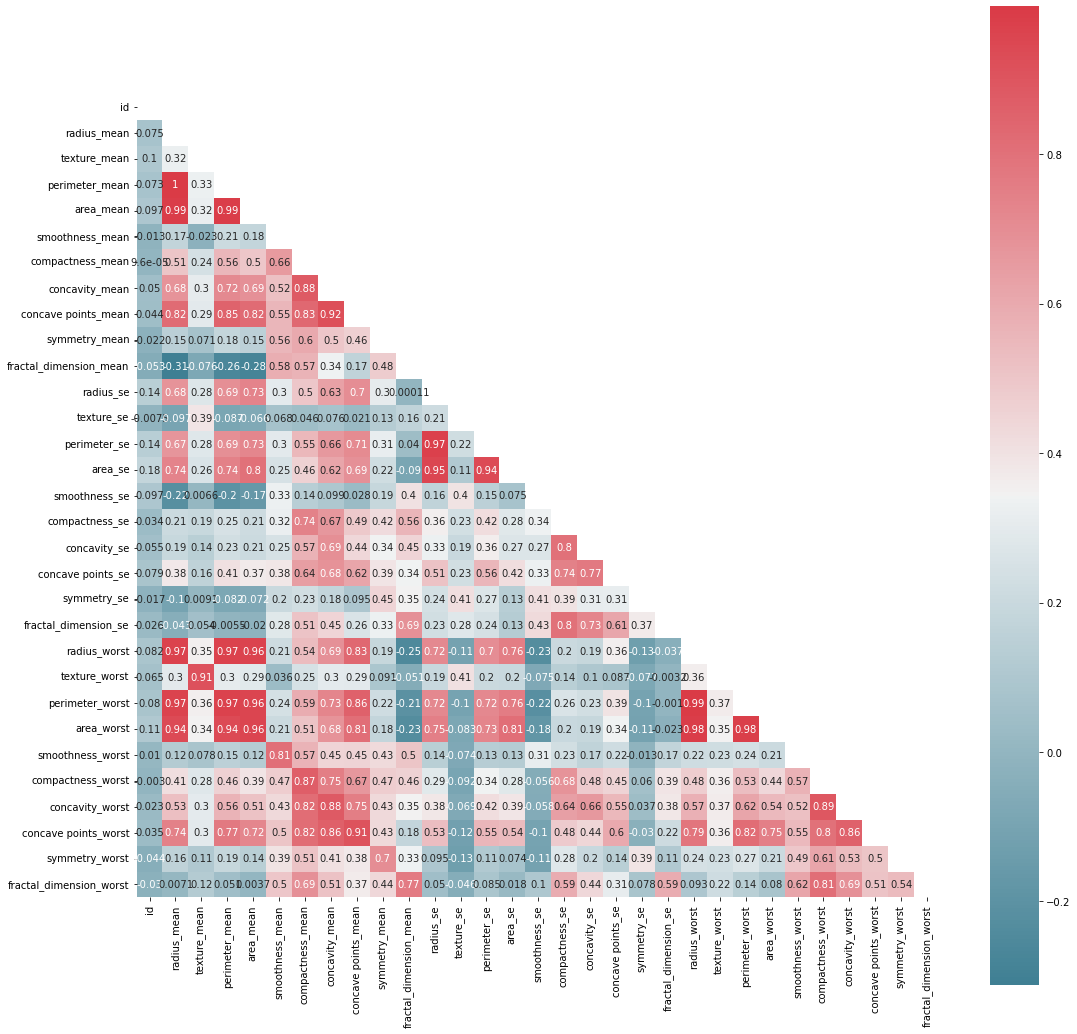

In [8]:
# Set up the matplotlib figure

plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(),mask = mask,square = True,annot=True,cmap=cmap)
plt.show()


### 3. Logistic Regression Model

#### 3.1 Use Logistic Regression

Use Logistic Regression and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [13]:
X = df.iloc[:,2:32]
y = df["diagnosis"].replace(to_replace = ["M","B"],value = [1,0])

In [38]:
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)
scaler = StandardScaler()
logreg = LogisticRegression()
logreg_model = make_pipeline(scaler,logreg)
logreg_model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



<AxesSubplot:>

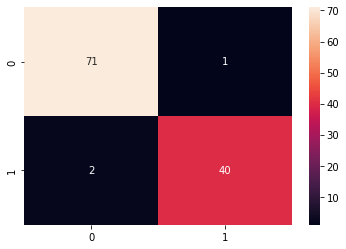

In [14]:
y_test_predict = logreg_model.predict(X_test)
logreg_report = classification_report(y_test, y_test_predict)
print(logreg_report)
logreg_cm = confusion_matrix(y_test,y_test_predict)
logreg_cm
sns.heatmap(logreg_cm,annot = True)

### 4. Support Vector Machine

#### 4.1 Use Support Vector Machine

Use Support Vector Machine and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [66]:
svc_model = make_pipeline(scaler,SVC(probability = True))
svc_model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

In [67]:
y_test_svc_predict = svc_model.predict(X_test)
svc_report = classification_report(y_test,y_test_svc_predict)
print(svc_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



<AxesSubplot:>

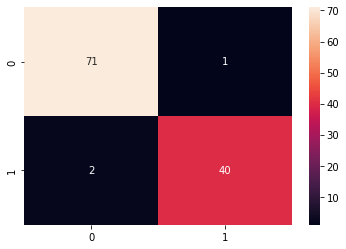

In [68]:
svc_cm = confusion_matrix(y_test,y_test_svc_predict)
sns.heatmap(svc_cm,annot = True)

### 5. Naive Bayes
#### 5.1 Use Naive Bayes

Use Naive Bayes and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [18]:
nb_model = make_pipeline(scaler,GaussianNB())
nb_model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [19]:
y_test_nb_predict = nb_model.predict(X_test)
nb_report = classification_report(y_test, y_test_nb_predict)
print(nb_report)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



<AxesSubplot:>

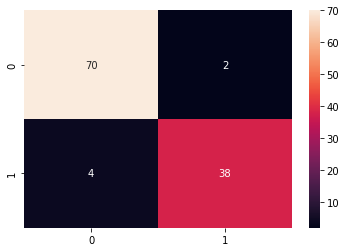

In [20]:
nb_cm = confusion_matrix(y_test,y_test_nb_predict)
sns.heatmap(nb_cm, annot=True)

### 6 Gridsearch optimal parameters for all three models.

Is there any difference between accuracy score of Logistic Regression and SVM? Use grid serach to find optimal parameter for both these models.

> Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

> It is possible and recommended to search the hyper-parameter space for the best cross validation score.

> https://scikit-learn.org/stable/modules/grid_search.html#grid-search

**Note:** It'll take time to execute this. After running the cell, wait for result.

#### 6.1 Find Best Estimator For Logistic Regression 

Find out how these parameters effect model. Find out the best estimator, score.

In [51]:
lr_params = {
    'penalty': ['l1','l2'],
    'C': [1, 10, 100]
}
lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)
X_scaled = scaler.transform(X)
lr_gs.fit(X_scaled,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/linhvien/opt/anaconda3/envs/iod/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/linhvien/opt/anaconda3/envs/iod/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100], 'penalty': ['l1', 'l2']},
             verbose=1)

In [55]:
print(lr_gs.best_params_)
print(lr_gs.best_score_)

{'C': 1, 'penalty': 'l2'}
0.9806862288464524


#### 6.2 Find Best Estimator For SVM

Find out how these parameters effect model. Find out the best estimator, score.

In [58]:
svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}

svc_gs = GridSearchCV(SVC(),svc_params,cv =5,verbose = 1)
svc_gs.fit(X_scaled,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=1)

In [59]:
print(svc_gs.best_params_)
print(svc_gs.best_score_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.9736531594472908


#### 6.3 Plot the ROC curve for the SVM, Logistic Regressions and Naive Bayes on the same plot

Find out which model performs better.

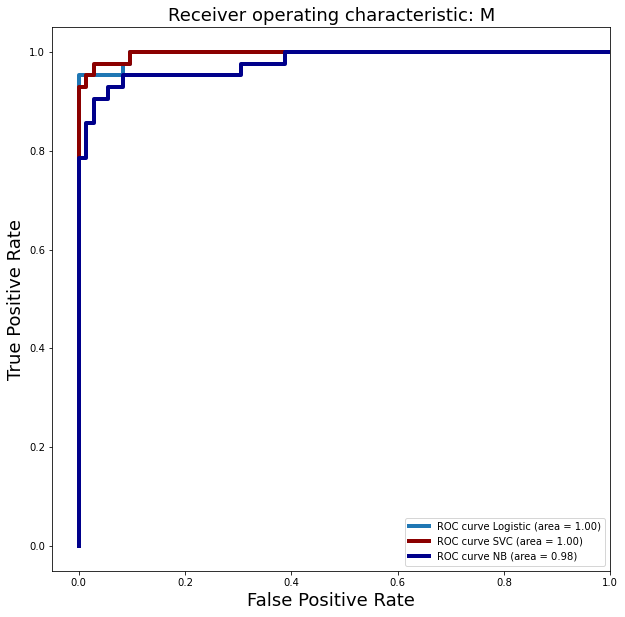

In [81]:
yhat_pp_lin = logreg_model.predict_proba(X_test)
yhat_pp = svc_model.predict_proba(X_test)
yhat_pp_nb = nb_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, yhat_pp_lin[:,1], pos_label=1)
fpr_svc, tpr_svc, _ = roc_curve(y_test, yhat_pp[:,1], pos_label=1)
fpr_nb, tpr_nb, _ = roc_curve(y_test, yhat_pp_nb[:,1], pos_label=1)

plt.figure(figsize=[10,10])

plt.plot(fpr, tpr, label='ROC curve Logistic (area = %0.2f)' % auc(fpr, tpr), linewidth=4)
plt.plot(fpr_svc, tpr_svc, label='ROC curve SVC (area = %0.2f)' % auc(fpr_svc, tpr_svc), linewidth=4, color='darkred')
plt.plot(fpr_nb, tpr_nb, label='ROC curve NB (area = %0.2f)' % auc(fpr_nb, tpr_nb), linewidth=4, color='darkblue')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: M', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### 7. [BONUS] Learning Curve

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.

Plot "learning curves" for the best models of each. This is a great way see how training/testing size affects the scores. Look at the documentation for how to use this function in sklearn.

http://scikit-learn.org/stable/modules/learning_curve.html#learning-curves

In [24]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

/Users/linhvien/opt/anaconda3/envs/iod/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/linhvien/opt/anaconda3/envs/iod/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


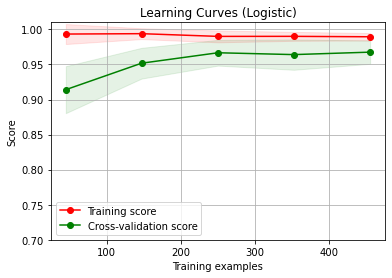

In [88]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

target_col = 'diagnosis'
feature_cols = [c for c in df.columns if c != target_col]

X =  df[feature_cols]
y =  df[target_col]
title = "Learning Curves (Logistic)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
estimator = LogisticRegression(C = 70.17038286703837, penalty = 'l1', solver = 'liblinear')
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show();

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)

[Validation curves: plotting scores to evaluate models](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curves)

[In-Depth: Support Vector Machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

[Understanding Support Vector Machine algorithm from examples (along with code)](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)

[Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)



---



---



> > > > > > > > > © 2022 Institute of Data


---



---



